In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry
from backtesting.backtester import BacktestEngine
from investor.portfolio_registry import PortfolioRegistry

In [3]:
portfolio_registry = PortfolioRegistry()
portfolio_registry.available()

['default']

In [4]:
default_portfolio = portfolio_registry.get('default')

In [5]:
tickers = ["SPY", "AAPL", "MSFT", "AMZN", "META", "GOOGL", "AVGO", "BRK-B"]  # List of tickers
data = {ticker: pd.read_parquet(os.path.join(data_path, f"{ticker}.parquet")) for ticker in tickers}
data = {tk: df.loc[default_portfolio.initial_time:] for tk, df in data.items()}
data

{'SPY':                             close    high       low    open     volume  \
 date                                                                     
 2023-01-03 00:00:00+00:00  380.82  386.43  377.8310  384.37   74850731   
 2023-01-04 00:00:00+00:00  383.76  385.88  380.0000  383.18   85934098   
 2023-01-05 00:00:00+00:00  379.38  381.84  378.7600  381.72   76970456   
 2023-01-06 00:00:00+00:00  388.08  389.25  379.4127  382.61  104189603   
 2023-01-09 00:00:00+00:00  387.86  393.70  387.6700  390.37   73978071   
 ...                           ...     ...       ...     ...        ...   
 2025-05-12 00:00:00+00:00  582.99  583.00  577.0400  581.47   78993570   
 2025-05-13 00:00:00+00:00  586.84  589.08  582.8400  583.41   67947225   
 2025-05-14 00:00:00+00:00  587.59  588.98  585.5350  587.81   66283531   
 2025-05-15 00:00:00+00:00  590.46  590.97  585.0969  585.56   71268145   
 2025-05-16 00:00:00+00:00  594.20  594.50  589.2800  591.25   71977042   
 
                

In [6]:
data['SPY'].head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2023-01-03 00:00:00+00:00,380.82,386.43,377.8310,384.37,74850731,369.221359,374.660495,366.323395,372.663236,74850731,0.0,1.0
2023-01-04 00:00:00+00:00,383.76,385.88,380.0000,383.18,85934098,372.071815,374.127246,368.426333,371.509480,85934098,0.0,1.0
2023-01-05 00:00:00+00:00,379.38,381.84,378.7600,381.72,76970456,367.825217,370.210293,367.224100,370.093947,76970456,0.0,1.0
2023-01-06 00:00:00+00:00,388.08,389.25,379.4127,382.61,104189603,376.260241,377.394606,367.856921,370.956841,104189603,0.0,1.0
2023-01-09 00:00:00+00:00,387.86,393.70,387.6700,390.37,73978071,376.046941,381.709072,375.862728,378.480494,73978071,0.0,1.0


In [7]:
signal_registry = SignalRegistry()

In [8]:
signal_registry.available_signals()

['ma_crossover', 'Kalman']

In [9]:
model2 = signal_registry.get('ma_crossover')()
model3 = signal_registry.get('Kalman')()

In [10]:
bt = BacktestEngine(
    data = data, 
    modules_weights = [(model3, 1)], 
    portfolio=default_portfolio
)

In [11]:
bt.run()

Backtesting: 100%|██████████| 595/595 [00:03<00:00, 195.42it/s]


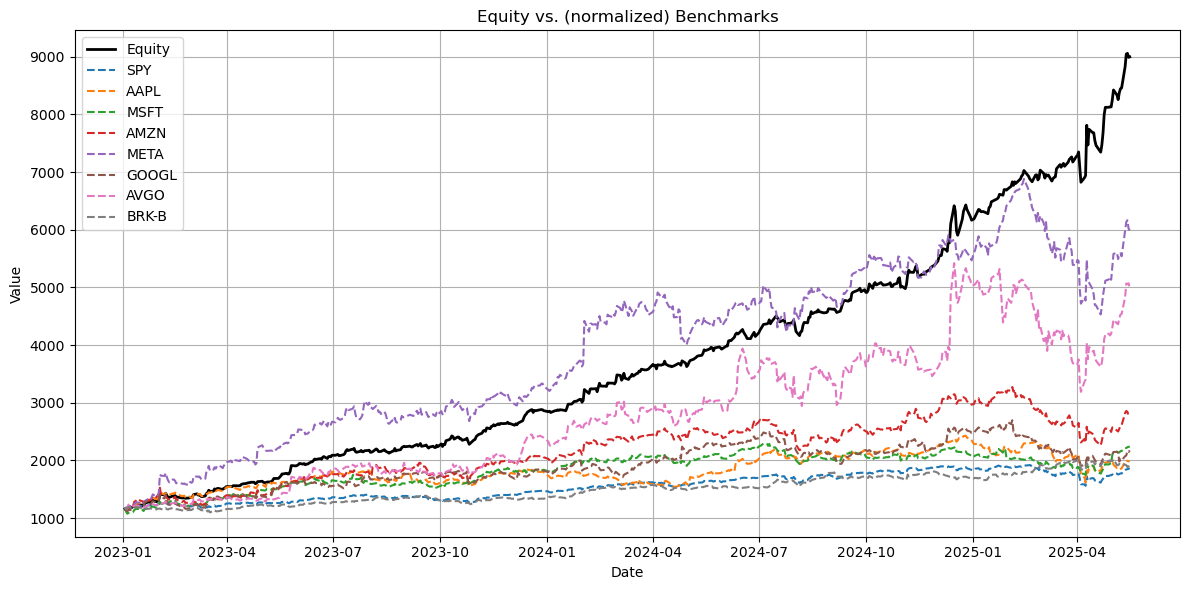

In [12]:
bt.equity_vs_benchmarks(benchmarks=tickers)

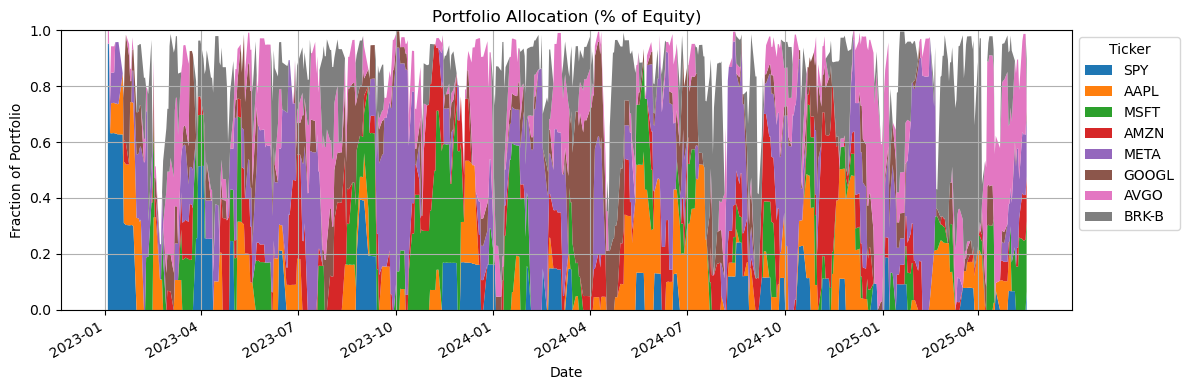

In [13]:
bt.holdings_over_time()

In [14]:
bt.portfolio.positions

{'SPY': 1,
 'NVDA': 2,
 'AVGO': 0,
 'TSLA': 1,
 'META': 3.0,
 'AAPL': 0.0,
 'GOOGL': 2.0,
 'AMZN': 7.0,
 'BRK-B': 3.0,
 'MSFT': 5.0}

In [17]:
bt.portfolio.order_history

[{'ticker': 'SPY',
  'timestamp': '2023-01-05T00:00:00+00:00',
  'size': -1,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'META',
  'timestamp': '2023-01-05T00:00:00+00:00',
  'size': 1,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'AAPL',
  'timestamp': '2023-01-06T00:00:00+00:00',
  'size': 1,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'AVGO',
  'timestamp': '2023-01-06T00:00:00+00:00',
  'size': 1,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'AVGO',
  'timestamp': '2023-01-10T00:00:00+00:00',
  'size': -2,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'META',
  'timestamp': '2023-01-10T00:00:00+00:00',
  'size': 1,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'META',
  'timestamp': '2023-01-17T00:00:00+00:00',
  'size': -2.0,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'AAPL',
  'timestamp': '2023-01-17T00:00:00+00:00',
  'size': 1,
  'price': 0.0,
  'commission': 0.0},
 {'ticker': 'SPY',
  'timestamp': '2023-01-18T00:00:00+00:00',
  'size': -1,

In [24]:
len([order for order in bt.portfolio.order_history if order['ticker'] == 'BRK-B'])

120